# Job Requirements

# Imports, Global Variables & Utility Functions

In [61]:
# built-in packages
import os
import pickle
import time
from pprint import pprint
from typing import List, Dict, Tuple, Union, Optional, Any 
import posixpath
import json
import regex as re
import ast
import js2py

# note (source: phind.ai): we are not using urllib due its unpredictability. 
#       for example, if the base url doesn't have a trailing slash,
#       urllib will not join the base url with the rel\ative url correctly.
#       Moreover, if the second url has a leading slash, urllib will ignore the base url.
# from urllib.parse import urljoin, 

# pip-installed packages
import requests
from bs4 import BeautifulSoup
import pandas as pd
from benedict import benedict

# secret variables
# create a directory called secretss, 
# and in it, create a file called secret_variables.py
# and in that file, create 2 dictionaries obtained from https://curlconverter.com/:
# 1. headers
# 2. cookies
# and then after import, use them as follows:
# headers = secret_variables.headers
# cookies = secret_variables.cookies
from secretss import secret_variables

In [62]:
# global variables
COUNTRIES = ['india', 'uae']
BASE_OUTPUT_URL = 'outputs'
EXCEL_DIR = 'excel_files'
CSV_DIR = 'csv_files'

# global constants
BASE_URL = "https://www.zomato.com/"

In [63]:
def save_pkl(content_to_be_saved, path) -> None:
    """
    Save the given content to a file using pickle serialization.

    Args:
        content_to_be_saved: Any serializable object.
        path (str): The full path to the file where the data will be saved.

    Example:
        >>> save_pkl({'name': 'John', 'age': 30}, 'data.pkl')

    Returns:
        None

    Notes:
        "path" could either mean relative path or absolute path.
    """
    with open(path, 'wb') as f:
        pickle.dump(content_to_be_saved, f)

def load_pkl(path:str) -> Union[bool, any]:
    """
    Load data from a file using pickle deserialization.

    Args:
        path (str): The full path to the file to be loaded.

    Example:
        >>> loaded_data = load_pkl('data.pkl')

    Returns:
        The loaded content if the file exists, or False if the file does not exist.

    Notes:
        "path" could either mean relative path or absolute path.
    """
    if not os.path.exists(path):
        return False
    with open(path, 'rb') as f:
        content = pickle.load(f)
    return content

def force_load_pkl(path:str, dtype:str='dict') -> any:
    """
    Load data from a file using pickle deserialization. If the file does not exist,
    create an empty file and return an empty dictionary or list based on the specified data type.

    Args:
        path (str): The full path to the file to be loaded or created.
        dtype (str, optional): The data type to create if the file does not exist ('dict' or 'list').

    Example:
        >>> loaded_data = force_load_pkl('data.pkl', dtype='dict')

    Returns:
        The loaded content if the file exists, or an empty dictionary or list if the file does not exist.

    Notes:
        "path" could either mean relative path or absolute path.
    """
    try:
        content = load_pkl(path)
        return content
    except Exception as e:
        if dtype == 'list':
            save_pkl([], path)
            return []
        else:
            save_pkl({}, path)
            return {}

def join_paths(base_path:str, *relative_paths:str) -> str:
    """
    Join two paths and normalize the result.

    Args:
        base_directory (str): The base directory path.
        relative_path (str): The relative path to be joined.

    Example:
        >>> result = join_paths('/user/documents', 'files/myfile.txt')

    Returns:
        The normalized and joined path.

    Notes:
        More about naming standards for path components here: https://stackoverflow.com/a/2235762
    """
    return os.path.normpath(os.path.join(base_directory, relative_path))

def change_sep(path:str, new_sep:str, old_sep:str=os.path.sep) -> str:
    """
    Change the path separator in a given path and normalize the result.

    Args:
        path (str): The input path.
        new_sep (str): The new path separator to use.
        old_sep (str, optional): The old path separator to replace (default is os.path.sep).

    Example:
        >>> result = change_sep('path/to/change', '/', '\\')

    Returns:
        The path with the new separator, normalized.

    Notes:
        Source 1: https://stackoverflow.com/questions/18707338/print-raw-string-from-variable-not-getting-the-answers#:~:text=To%20turn%20a%20variable%20to%20raw%20str%2C%20just%20use
        Source 2: https://mail.python.org/pipermail/tutor/2011-July/084788.html
    """
    return os.path.normpath(rf"{path}").replace(old_sep, new_sep)


In [64]:
def save_df(df:pd.DataFrame, file_name_without_ext:str, to_excel:bool=True, to_csv:bool=True) -> None:
    """
    Save a dataframe to excel and csv files.
    """
    excel_path = join_paths(BASE_OUTPUT_URL, EXCEL_DIR, file_name_without_ext + '.xlsx')
    csv_path = join_paths(BASE_OUTPUT_URL, CSV_DIR, file_name_without_ext + '.csv')
    
    # check if the paths exist, and if not, create them
    if not os.path.exists(os.path.dirname(excel_path)):
        os.makedirs(os.path.dirname(excel_path))
    if not os.path.exists(os.path.dirname(csv_path)):
        os.makedirs(os.path.dirname(csv_path))

    if to_excel:
        df.to_excel(os.path.join(BASE_OUTPUT_URL, EXCEL_DIR, file_name_without_ext + '.xlsx'), index=False)
    if to_csv:
        df.to_csv(os.path.join(BASE_OUTPUT_URL, CSV_DIR, file_name_without_ext + '.csv'), index=False)

In [65]:
def _conversion_logic(v) -> Any:
    if isinstance(v, str):
        try:
            # convert into a dict/list if it's a JSON string
            v = json.loads(v)  
        except json.JSONDecodeError:
            # leave value as is otherwise
            pass  
    if isinstance(v, dict) or isinstance(v, list):
        # convert dict's/list's strings using _recurse_convert_collections function 
        return _recurse_convert_collections(v)  
    else:
        # if it's not a string, dict, or list, leave value as is
        return v

def _recurse_convert_collections(data:Union[dict, list]) -> Union[dict, list]:
    try:
        iterable = data.items() if isinstance(data, dict) else enumerate(data)
    except:
        raise('The input data is not a dict, or list.')
    
    for k_or_i, v in iterable:
        data[k_or_i] = _conversion_logic(v)

    return data

def to_benedict_dict(data:Union[str, dict, List[dict]]) -> benedict:
    if isinstance(data, str):
        try:
            data = json.loads(data)
        except json.JSONDecodeError:
            raise('The input data is not a valid JSON string.')
    
    if isinstance(data, dict) or isinstance(data, list):
        json_dict_or_list = _recurse_convert_collections(data)
        return benedict(json_dict_or_list)
    else:
        raise('The input data is not a valid JSON string, dict, or list.')

In [66]:
def benedict_dict_find_and_replace(bdict:benedict, keypath_sub_strings:List[str], new_value:Any, 
                                   matching_method:str='all', concat_list=False, inplace=False) -> Any:
    '''
    caveat 1: if new_value is a list, then the final value of keypath_sub_strings[-1]
            must refer to the final keypath whose value is the list to be replaced.

    caveat 2: if new_value is a list, and you would like to concat the list instead of replacing it,
            then set concat_list=True.
    '''        
    old_val = None
    kps = bdict.keypaths(indexes=True)
    
    if not inplace:
        bdict = bdict.deepcopy()
        
    for kp in kps:
        all_cond = (matching_method == 'all' and all([sub_str in kp for sub_str in keypath_sub_strings]))
        any_cond = (matching_method != 'all' and any([sub_str in kp for sub_str in keypath_sub_strings]))
        if_list_then_not_idx_cond = (not isinstance(new_value, list) or f'{keypath_sub_strings[-1]}[' not in kp)

        if (all_cond or any_cond) and if_list_then_not_idx_cond:
            old_val = bdict.get(kp, None)
            if concat_list and isinstance(bdict[kp], list):
                bdict[kp].extend(new_value)
            else:
                bdict[kp] = new_value
    if inplace:
        return old_val
    else:
        return bdict
    
def benedict_dict_multi_find_and_replace(bdict:benedict, keypath_sub_string_per_new_value:List[str], 
                                         new_values:List[Any], concat_list=False, inplace=False) -> Any:
    '''
    caveat 1: if new_value[i] is a list, then the value of  keypath_sub_string_per_new_value[i]
            must refer to the final key in the keypath whose value is the list to be replaced.

    caveat 2: if new_value[i] is a list, and you would like to concat the list instead of replacing it,
            then set concat_list=True.
    '''        
    old_val = None
    kps = bdict.keypaths(indexes=True)
    
    if not inplace:
        bdict = bdict.deepcopy()
        
    # in kps, find string which has keypath_sub_strings_per_new_value[i] as a substring in it, and store that kp:
    for i, keypath_sub_string in enumerate(keypath_sub_string_per_new_value):
        for kp in kps:
            if_list_then_not_idx_cond = (not isinstance(new_values[i], list) or f'{keypath_sub_string}[' not in kp)
            if (keypath_sub_string in kp) and if_list_then_not_idx_cond:
                old_val = bdict.get(kp, None)
                if concat_list and isinstance(bdict[kp], list):
                    bdict[kp].extend(new_values[i])
                else:
                    bdict[kp] = new_values[i]

    if inplace:
        return old_val
    else:
        return bdict

# Main Functions

# Main Code

In [67]:
for country in COUNTRIES:
    # create the country url
    country_url = posixpath.join(BASE_URL, country)
    print(f"Current Country URL: {country_url}")

    # use beautifulsoup to parse the html content
    country_html = requests.get(country_url, headers={'User-Agent': 'Mozilla/5.0'}).text
    country_soup = BeautifulSoup(country_html, 'html.parser')

    # get the list of cities
    cities = country_soup.select('div.states-container > div > div > div h5')
    cities = [city.text.strip().split(' Restaurants')[0] for city in cities]
    print(cities)
    
    # create the city url
    for i, city in enumerate(cities):
        city_url = posixpath.join(BASE_URL, city)
        print(f"Current City URL: {city_url}")
        break
    break


Current Country URL: https://www.zomato.com/india
['Agra', 'Ahmedabad', 'Ajmer', 'Alappuzha', 'Allahabad', 'Amravati', 'Amritsar', 'Aurangabad', 'Bengaluru', 'Bhopal', 'Bhubaneswar', 'Chandigarh', 'Chennai', 'Coimbatore', 'Cuttack', 'Darjeeling', 'Dehradun', 'Delhi NCR', 'Dharamshala', 'Gangtok', 'Goa', 'Gorakhpur', 'Guntur', 'Guwahati', 'Gwalior', 'Haridwar', 'Hyderabad', 'Indore', 'Jabalpur', 'Jaipur', 'Jalandhar', 'Jammu', 'Jamnagar', 'Jamshedpur', 'Jhansi', 'Jodhpur', 'Junagadh', 'Kanpur', 'Khajuraho', 'Khamgaon', 'Kharagpur', 'Kochi', 'Kolhapur', 'Kolkata', 'Kota', 'Lucknow', 'Ludhiana', 'Madurai', 'Manali', 'Mangalore', 'Manipal', 'Meerut', 'Mumbai', 'Mussoorie', 'Mysore', 'Nagpur', 'Nainital', 'Nashik', 'Neemrana', 'Ooty', 'Palakkad', 'Patiala', 'Patna', 'Puducherry', 'Pune', 'Pushkar', 'Raipur', 'Rajkot', 'Ranchi', 'Rishikesh', 'Salem', 'Shimla', 'Siliguri', 'Srinagar', 'Surat', 'Thrissur', 'Tirupati', 'Trichy', 'Trivandrum', 'Udaipur', 'Vadodara', 'Varanasi', 'Vellore', 'Vijay

# Drafts: Examples For Visualizing Functions' Return Values

In [68]:
cookies = secret_variables.cookies

headers = secret_variables.headers

json_data = {
    'context': 'delivery',
    'filters': '{"searchMetadata":{"previousSearchParams":"{\\"PreviousSearchId\\":\\"45912029-27c8-400b-b90a-35bd9d095b86\\",\\"PreviousSearchFilter\\":[\\"{\\\\\\"category_context\\\\\\":\\\\\\"delivery_home\\\\\\"}\\",\\"\\"]}","postbackParams":"{\\"processed_chain_ids\\":[19461231,19183764,19667147,3400169,20632393,19269047,19144718,3400105,19907337],\\"shown_res_count\\":9,\\"search_id\\":\\"45912029-27c8-400b-b90a-35bd9d095b86\\"}","totalResults":1267,"hasMore":true,"getInactive":false},"dineoutAdsMetaData":{},"appliedFilter":[{"filterType":"category_sheet","filterValue":"delivery_home","isHidden":true,"isApplied":true,"postKey":"{\\"category_context\\":\\"delivery_home\\"}"}],"urlParamsForAds":{}}',
    'addressId': 0,
    'entityId': 34,
    'entityType': 'city',
    'locationType': '',
    'isOrderLocation': 1,
    'cityId': 34,
    'latitude': '27.1800000000000000',
    'longitude': '78.0200000000000000',
    'userDefinedLatitude': 27.18,
    'userDefinedLongitude': 78.02,
    'entityName': 'Agra',
    'orderLocationName': 'Agra',
    'cityName': 'Agra',
    'countryId': 1,
    'countryName': 'India',
    'displayTitle': 'Agra',
    'o2Serviceable': True,
    'placeId': '14225',
    'cellId': '4140058016516931584',
    'deliverySubzoneId': 14225,
    'placeType': 'DSZ',
    'placeName': 'Agra',
    'isO2City': True,
    'fetchFromGoogle': False,
    'fetchedFromCookie': True,
    'isO2OnlyCity': False,
    'address_template': [],
    'otherRestaurantsUrl': '',
}

response = requests.post('https://www.zomato.com/webroutes/search/home', cookies=cookies, headers=headers, json=json_data)

# Note: json_data will not be serialized by requests
# exactly as it was in the original request.
#data = '{"context":"delivery","filters":"{\\"searchMetadata\\":{\\"previousSearchParams\\":\\"{\\\\\\"PreviousSearchId\\\\\\":\\\\\\"3b79eef9-c768-4d84-b487-2a1fa60aae2f\\\\\\",\\\\\\"PreviousSearchFilter\\\\\\":[\\\\\\"{\\\\\\\\\\\\\\"category_context\\\\\\\\\\\\\\":\\\\\\\\\\\\\\"delivery_home\\\\\\\\\\\\\\"}\\\\\\",\\\\\\"\\\\\\"]}\\",\\"postbackParams\\":\\"{\\\\\\"processed_chain_ids\\\\\\":[19748876,3400169,19468292,19183764,20470976,19461231,20129295,3400105,19382015],\\\\\\"shown_res_count\\\\\\":9,\\\\\\"search_id\\\\\\":\\\\\\"3b79eef9-c768-4d84-b487-2a1fa60aae2f\\\\\\"}\\",\\"totalResults\\":1455,\\"hasMore\\":true,\\"getInactive\\":false},\\"dineoutAdsMetaData\\":{},\\"appliedFilter\\":[{\\"filterType\\":\\"category_sheet\\",\\"filterValue\\":\\"delivery_home\\",\\"isHidden\\":true,\\"isApplied\\":true,\\"postKey\\":\\"{\\\\\\"category_context\\\\\\":\\\\\\"delivery_home\\\\\\"}\\"}],\\"urlParamsForAds\\":{}}","addressId":0,"entityId":34,"entityType":"city","locationType":"","isOrderLocation":1,"cityId":34,"latitude":"27.1800000000000000","longitude":"78.0200000000000000","userDefinedLatitude":27.18,"userDefinedLongitude":78.02,"entityName":"Agra","orderLocationName":"Agra","cityName":"Agra","countryId":1,"countryName":"India","displayTitle":"Agra","o2Serviceable":true,"placeId":"14225","cellId":"4140058016516931584","deliverySubzoneId":14225,"placeType":"DSZ","placeName":"Agra","isO2City":true,"fetchFromGoogle":false,"fetchedFromCookie":true,"isO2OnlyCity":false,"address_template":[],"otherRestaurantsUrl":""}'
#response = requests.post('https://www.zomato.com/webroutes/search/home', cookies=cookies, headers=headers, data=data)

In [69]:
resp = requests.get('https://www.zomato.com/agra', cookies=cookies, headers=headers)
resp.status_code

200

In [70]:
# checking json_data to see how we can replicate this data 
# when automating the process of making requests
json_data = to_benedict_dict(json_data)
pprint(json_data)

{'addressId': 0,
 'address_template': [],
 'cellId': 4140058016516931584,
 'cityId': 34,
 'cityName': 'Agra',
 'context': 'delivery',
 'countryId': 1,
 'countryName': 'India',
 'deliverySubzoneId': 14225,
 'displayTitle': 'Agra',
 'entityId': 34,
 'entityName': 'Agra',
 'entityType': 'city',
 'fetchFromGoogle': False,
 'fetchedFromCookie': True,
 'filters': {'appliedFilter': [{'filterType': 'category_sheet',
                                'filterValue': 'delivery_home',
                                'isApplied': True,
                                'isHidden': True,
                                'postKey': {'category_context': 'delivery_home'}}],
             'dineoutAdsMetaData': {},
             'searchMetadata': {'getInactive': False,
                                'hasMore': True,
                                'postbackParams': {'processed_chain_ids': [19461231,
                                                                           19183764,
                           

JSON.parse("{\"pages\":{\"current\":{\"name\":\"search\",\"pageTitle\":\"Checkout Best Food Places To Eat In Agra | Zomato\",\"pageDescription\":\"Looking for Best Food in Agra? Checkout the highest-rated restaurants in Agra and satisfy your food cravings now!\",\"pageUrl\":\"/agra\",\"title\":\"Checkout Best Food Places To Eat In Agra | Zomato\",\"isNoIndex\":false,\"ogTitle\":\"Checkout Best Food Places To Eat In Agra | Zomato\",\"ogDescription\":\"Looking for Best Food in Agra? Checkout the highest-rated restaurants in Agra and satisfy your food cravings now!\",\"ogPageUrl\":\"/agra\",\"subType\":\"delivery\",\"isMobile\":0,\"isTablet\":0,\"isOAuthV2Enabled\":false,\"useAuthSdkForLogin\":true,\"useAuthSdkForLogout\":false,\"gaPageType\":\"City\"},\"contact\":{\"contactPageBannerData\":[],\"snippetData\":[],\"formData\":{},\"buisinessEnquiriesData\":{}},\"gift\":{\"crystalData\":{}},\"goodbye\":{},\"restaurant\":{},\"awards\":{\"cities\":[],\"cityWinners\":[],\"currentCity\":{},\"loa
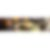
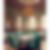
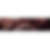
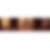

In [71]:
# fetching data in JSON.parse() found in the <script> tag of the response's HTML:
pattern = r'(JSON\.parse\(.*\);)'
matches = re.findall(pattern, resp.text)[0]
print(matches)

{'aboutus': {'leadershipData': []},
 'allJobs': {'filters': [], 'openings': []},
 'apiState': {},
 'backButton': {'showLoadingState': False},
 'blogData': {'blogs': [], 'error': None, 'isfetching': None},
 'careers': {'departments': []},
 'department': {},
 'deviceSpecificInfo': {'browser': {'name': 'Chrome',
                                    'platform': 'windows',
                                    'userAgent': 'Mozilla/5.0 (Windows NT '
                                                 '10.0; Win64; x64) '
                                                 'AppleWebKit/537.36 (KHTML, '
                                                 'like Gecko) Chrome/116.0.0.0 '
                                                 'Safari/537.36',
                                    'version': '116.0.0.0'}},
 'doesNotDeliverModal': {'isVisible': False},
 'entities': {'ADDRESSES': {},
              'AD_BANNERS': {},
              'CDNG_ORDER': {},
              'COLLECTIONS': {'20': {'id': 20,
        
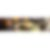
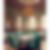
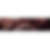
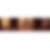

In [72]:
# converting JavaScript code to Python dictionary using js2py library
# source 1: https://stackoverflow.com/a/72767768/13626137
# source 2: https://github.com/PiotrDabkowski/Js2Py 
js_script_dict = to_benedict_dict(js2py.eval_js(matches).to_dict())
pprint(js_script_dict)

In [73]:
# by comparing the differences between 2 XHR outputs (obtained by scrolling through webpage to fetch new restaurants)  
# and byinspecting json_data, and the JSON.parse() data in the code above, 
# we need to do the following to go through all the restaurants (that are counted in 'totalResults' btw):
    # when we first make a get request to the city url, we get a response with HTML that has a <script> tag
    # this <script> tag, when processed to a dict, has a key called 
    # 'postbackParams' which contains the two keys that change from one XHR request to another:
    # 'processed_chain_ids' and 'shown_res_count'
js_script_search_res = js_script_dict.search('postbackParams', in_keys=True, in_values=False,
                                            exact=True, case_sensitive=False)
js_script_search_res

[({'filterInfo': {'modalFilters': {'verticalTabs': [{'key': 'sort_modal', 'name': 'Sort by'}, {'key': 'cuisine_modal', 'name': 'Cuisines'}, {'key': 'rating_modal', 'name': 'Rating'}, {'key': 'cfo_modal', 'name': 'Cost per person'}, {'key': 'more_filters_modal', 'name': 'More filters'}], 'verticalTabsValue': {'cfo_modal': [{'filterType': 'cfo', 'filterValue': 20000000, 'name': '₹2,00,00,000', 'postKey': {'cfo': [20000000]}}, {'filterType': 'cfo', 'filterValue': 600, 'name': '₹600', 'postKey': {'cfo': [600]}}, {'filterType': 'cfo', 'filterValue': 300, 'name': '₹300', 'postKey': {'cfo': [300]}}, {'filterType': 'cfo', 'filterValue': 150, 'name': '₹150', 'postKey': {'cfo': [150]}}, {'filterType': 'cfo', 'filterValue': 0, 'name': '₹0', 'postKey': {'cfo': [0]}}], 'cuisine_modal': [{'filterType': 'cuisine_id', 'filterValue': 984, 'name': 'Abruzzese', 'postKey': {'cuisine_id': [984]}}, {'filterType': 'cuisine_id', 'filterValue': 237, 'name': 'Aceh', 'postKey': {'cuisine_id': [237]}}, {'filterTy

In [74]:
# getting required keys for iterating through all restaurants:
js_script_postparams_dict = benedict(js_script_search_res[0][2])
js_processed_chain_ids = js_script_postparams_dict.get('processed_chain_ids')
js_shown_res_count = js_script_postparams_dict.get('shown_res_count')
js_processed_chain_ids, js_shown_res_count

([19144718,
  19461231,
  19667147,
  19183764,
  19907337,
  3400169,
  19762292,
  19269047,
  19468292],
 9)

In [80]:
# another quicker method of getting the required keys:
# you have to set indexes=True for regex to search through index keypaths (e.g., processed_chain_ids[0])
# in general, it is preferable to set indexes=True for all searches
js_processed_chain_ids = js_script_dict.match('.*processed_chain_ids\[', indexes=True)
js_shown_res_count = js_script_dict.match('.*shown_res_count', indexes=True)
if len(js_shown_res_count) > 0:
    js_shown_res_count = js_shown_res_count[0]
else:
    js_shown_res_count = len(js_processed_chain_ids)

js_totalresults = js_script_dict.match('.*totalResults', indexes=True)
if len(js_totalresults) > 0:
    js_totalresults = js_totalresults[0]
else:
    # any arbitrary high number of restaruant results,
    # either way, the regex should always match
    js_totalresults = 3000 

# a simpler condition can be done by checking hasMore key
js_hasmore = js_script_dict.match('.*hasMore', indexes=True)
if len(js_hasmore) > 0:
    js_hasmore = js_hasmore[0]
else:
    js_hasmore = True

js_processed_chain_ids, js_shown_res_count, js_totalresults, js_hasmore

([19144718,
  19461231,
  19667147,
  19183764,
  19907337,
  3400169,
  19762292,
  19269047,
  19468292],
 9,
 1338,
 [True])

In [38]:
# now, if we were to make a new request, but with the new values of 'processed_chain_ids' and 'shown_res_count',
# we would get a new JSON response where we can fetch the new resid's (restaurant id's) and add that as the new 'processed_chain_ids'
# and so on and so forth until we reach the 'totalResults' count
# so, let's do that now:
new_json_data = benedict_dict_multi_find_and_replace(json_data, ['processed_chain_ids', 'shown_res_count'], 
                                                    [js_processed_chain_ids, js_shown_res_count], 
                                                    inplace=False)

In [57]:
# since I've previously copied json_data from https://curlconverter.com/,
# the 'processed_chain_ids' and 'shown_res_count' values are the same as the ones in the new_json_data
# so now let's see the response and fetch the new 'processed_chain_ids' and 'shown_res_count' values
# so that we can make a new request with those values and repeat the process until we reach the 'totalResults' count

# fetching the new 'processed_chain_ids' and 'shown_res_count' values
resp_dict = benedict(response.json())
resp_resids = resp_dict.match(r'.*resId', indexes=True)
resp_shown_res_count = len(resp_resids)
resp_resids, resp_shown_res_count

([3400425,
  3400021,
  3400238,
  19726862,
  18899460,
  18889778,
  19257735,
  3401492,
  3401244,
  3401284,
  3400005,
  19136275],
 12)

In [58]:
# now let's make a new request with the new 'processed_chain_ids' and 'shown_res_count' values
new_json_data = benedict_dict_multi_find_and_replace(json_data, ['processed_chain_ids', 'shown_res_count'], 
                                                    [resp_resids, resp_shown_res_count], 
                                                    inplace=False)

# making a new request with the new 'processed_chain_ids' and 'shown_res_count' values
response = requests.post('https://www.zomato.com/webroutes/search/home', cookies=cookies, headers=headers, json=new_json_data)
response.status_code

200

In [59]:
# now, if we fetch the new resids, they should be different than the previous ones
# therefore, we've got a consistant way of fetching all the restaurants' data
resp_dict = benedict(response.json())
resp_resids = resp_dict.match(r'.*resId', indexes=True)
resp_shown_res_count = len(resp_resids)
resp_resids, resp_shown_res_count

([3401744,
  18888066,
  3400017,
  20551316,
  19314048,
  19633307,
  19359199,
  20601060,
  19969003,
  18942402,
  3400016,
  20626134],
 12)

In [37]:
# draft: trying out the find_and_replace function:
pprint(benedict_dict_find_and_replace(json_data, ['category_context'], 5555555555555555555555555555555, 
                                      matching_method='all', inplace=False))

{'addressId': 0,
 'address_template': [],
 'cellId': 4140058016516931584,
 'cityId': 34,
 'cityName': 'Agra',
 'context': 'delivery',
 'countryId': 1,
 'countryName': 'India',
 'deliverySubzoneId': 14225,
 'displayTitle': 'Agra',
 'entityId': 34,
 'entityName': 'Agra',
 'entityType': 'city',
 'fetchFromGoogle': False,
 'fetchedFromCookie': True,
 'filters': {'appliedFilter': [{'filterType': 'category_sheet',
                                'filterValue': 'delivery_home',
                                'isApplied': True,
                                'isHidden': True,
                                'postKey': {'category_context': 5555555555555555555555555555555}}],
             'dineoutAdsMetaData': {},
             'searchMetadata': {'getInactive': False,
                                'hasMore': True,
                                'postbackParams': {'processed_chain_ids': [19461231,
                                                                           19183764,
           